# References

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1

from pathlib import Path
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary

import fastai
from fastai import *
from fastai.vision import *
from fastai.vision.image import *

# Global Variables

In [3]:
torch.cuda.set_device(0)

DP = Path('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs_512'
TEST_PNGS = 'test_pngs_512'
TRAIN_CSV = 'train.csv'
SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'


SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 512
original_img_sz = 512
bs = 64
val_split = 0.2
np.random.seed(42)

# Data

## Image opener function

In [4]:
def open_4_channel(fname):
    fname = str(fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32).float())

## Fastai data_block api

In [5]:
src = (ImageItemList.from_csv(STAGE_ONE_DATA, TRAIN_CSV, folder=TRAIN_PNGS, suffix='.png')
       .random_split_by_pct(val_split)
       .label_from_df(sep=' ',  classes=[str(i) for i in range(28)]))

In [6]:
src.train.x.create_func = open_4_channel

In [7]:
src.valid.x.create_func = open_4_channel

In [8]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(STAGE_ONE_DATA/TEST_PNGS)}))

In [9]:
test_fnames = [STAGE_ONE_DATA/TEST_PNGS/test_id for test_id in test_ids]

In [10]:
test_fnames[:5]

[PosixPath('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/test_pngs_512/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [11]:
src.add_test(test_fnames, label='0')

FileNotFoundError: [Errno 2] No such file or directory: '/home/Deep_Learner/work/network/datasets/human-protein-atlas-image-classification/stage1_data/train_pngs_512/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0.png'

In [12]:
src.test.x.create_func = open_4_channel

In [13]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [4]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [21]:
data = (src.transform((trn_tfms, _), size=sz)
        .databunch().normalize(protein_stats))

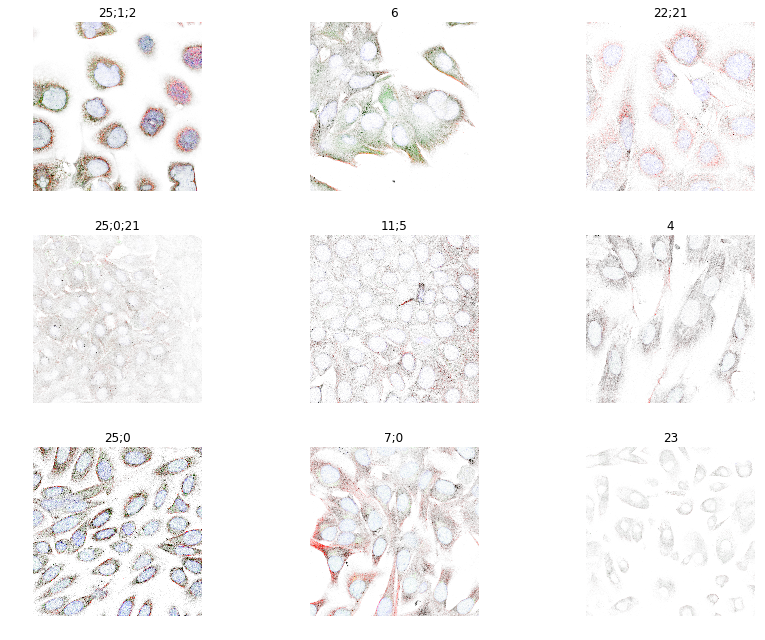

In [22]:
data.show_batch(rows=3, figsize=(12,9))

# Loss Function/Metrics

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()


f1_score = partial(fbeta, thresh=0.5, beta=1)

# Model

In [9]:
res = torchvision.models.resnet50(pretrained=True)

In [16]:
res.conv1.weight[:,:1,:,:].shape

torch.Size([64, 1, 7, 7])

In [17]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        self.encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        w = self.encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        #self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        self.conv1.weight = torch.nn.Parameter(torch.cat((w,w[:,:1,:,:]),dim=1))
        
        self.bn1 = self.encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4
        
        self.avgpool = self.encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)        
        
        ##not giving a good score
        #self.custom_head = fastai.vision.learner.create_head(nf = 512 * (1 if encoder_depth==34 else 4)*2, nc = num_classes)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        ##not giving a good score        
        #x = self.custom_head(x)
        
        return x

# Train

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Resnet4Channel(50).to(device)
summary(model, (4, sz, sz))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]          12,544
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BatchNorm2d-3         [-1, 64, 112, 112]             128
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,096
            Conv2d-7           [-1, 64, 56, 56]           4,096
       BatchNorm2d-8           [-1, 64, 56, 56]             128
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
           Conv2d-13           [-1, 64, 56, 56]          36,864
      BatchNorm2d-14           [-1, 64,

In [8]:
model

NameError: name 'model' is not defined

In [15]:
learn = ClassificationLearner(
    data=data,
    model=model,
    loss_func=F.binary_cross_entropy_with_logits,
    #loss_func=FocalLoss(),
    path=STAGE_ONE_DATA,    
    metrics=[f1_score]
)

#learn = create_cnn(data=data, arch=model, metrics=[f1_score])

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


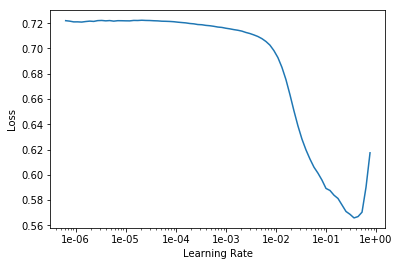

In [18]:
learn.recorder.plot()

In [20]:
lr = 1e-1

In [21]:
#learn.freeze_to(-12)

In [22]:
#learn.fit(1, lr)

In [23]:
#learn.unfreeze()

In [24]:
learn.fit_one_cycle(20, slice(lr))

Total time: 1:42:50
epoch  train_loss  valid_loss  fbeta    
1      0.166507    0.169505    0.082455   (05:08)
2      0.169886    0.367041    0.188674   (05:07)
3      0.173509    2137.328125  0.159403  (05:05)
4      0.184185    19.522430   0.259109   (05:10)
5      0.204276    3.654228    0.013249   (05:08)
6      0.220206    4671.480957  0.034348  (05:08)
7      0.200705    936.429565  0.028875   (05:09)
8      0.196299    0.241009    0.253770   (05:08)
9      0.185453    1.045191    0.324202   (05:08)
10     0.180938    6361.982910  0.184979  (05:09)
11     0.175172    0.176103    0.348905   (05:09)
12     0.173705    0.167588    0.216727   (05:07)
13     0.164847    2.019491    0.273615   (05:09)
14     0.155390    0.167999    0.296350   (05:09)
15     0.150807    0.204263    0.281296   (05:09)
16     0.148605    0.196750    0.184950   (05:07)
17     0.138646    0.164029    0.352107   (05:08)
18     0.136981    0.139933    0.407285   (05:09)
19     0.133402    0.142661    0.398346

In [25]:
learn.save('resnet50_sz224_bs64_fastaiCustomHead')

# Predictions

In [26]:
preds,_ = learn.get_preds(DatasetType.Test)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1129: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [27]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':df_test.Id,'Predicted':pred_labels})
df.to_csv(SUBMISSIONS/'resnet50_sz224_bs64_fastaiCustomHead.csv', header=True, index=False)